### Step 1: Create a Custom Imbalanced Dataset
#### We simulate a dictionary-based dataset to mimic real-world scenarios. For example, consider a binary classification problem (fraud detection) where the minority class (1) represents fraudulent cases.

##### A. Importing Libraries

In [5]:
import numpy as np
import pandas as pd

##### B. Creating our sample dataset

In [6]:
# Create synthetic data
np.random.seed(42)

# Majority class (Class 0)
majority_class = {
    "Feature1": np.random.normal(loc=50, scale=10, size=950),
    "Feature2": np.random.normal(loc=60, scale=15, size=950),
    "Feature3": np.random.normal(loc=30, scale=5, size=950),
    "Label": np.zeros(950, dtype=int),
}

# Minority class (Class 1)
minority_class = {
    "Feature1": np.random.normal(loc=70, scale=10, size=50),
    "Feature2": np.random.normal(loc=80, scale=15, size=50),
    "Feature3": np.random.normal(loc=40, scale=5, size=50),
    "Label": np.ones(50, dtype=int),
}

In [10]:
# Combine into a single dataset
data_dict = {key: np.concatenate([majority_class[key], minority_class[key]]) for key in majority_class}
df = pd.DataFrame(data_dict)

print(f"Class Distribution:\n{df['Label'].value_counts()}")

Class Distribution:
Label
0    950
1     50
Name: count, dtype: int64


### Step 2: Explore Techniques to Handle Imbalance
#### 1. Random Undersampling
##### Reduces the majority class to balance the dataset.

In [13]:
from imblearn.under_sampling import RandomUnderSampler

X = df[["Feature1", "Feature2", "Feature3"]]
y = df["Label"]

rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)

print("Class Distribution After Random Undersampling:")
print(pd.Series(y_resampled).value_counts())

Class Distribution After Random Undersampling:
Label
0    50
1    50
Name: count, dtype: int64


#### 2. Random Oversampling
##### Duplicates samples from the minority class.

In [14]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

print("Class Distribution After Random Oversampling:")
print(pd.Series(y_resampled).value_counts())

Class Distribution After Random Oversampling:
Label
0    950
1    950
Name: count, dtype: int64


#### 3. SMOTE (Synthetic Minority Oversampling Technique)
##### Generates synthetic samples for the minority class.

In [15]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

print("Class Distribution After SMOTE:")
print(pd.Series(y_resampled).value_counts())

Class Distribution After SMOTE:
Label
0    950
1    950
Name: count, dtype: int64


#### 4. Class Weighting
##### Use weighted loss functions during model training to handle imbalance.

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

clf = RandomForestClassifier(class_weight="balanced", random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print("Classification Report with Class Weighting:")
print(classification_report(y_test, y_pred))

Classification Report with Class Weighting:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       285
           1       0.82      0.60      0.69        15

    accuracy                           0.97       300
   macro avg       0.90      0.80      0.84       300
weighted avg       0.97      0.97      0.97       300



#### 5. Custom Sampling with a Pipeline
##### Combining resampling and model training in a pipeline.

In [17]:
from imblearn.pipeline import Pipeline

pipeline = Pipeline([
    ("smote", SMOTE(random_state=42)),
    ("classifier", RandomForestClassifier(random_state=42)),
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

print("Classification Report with SMOTE in Pipeline:")
print(classification_report(y_test, y_pred))

Classification Report with SMOTE in Pipeline:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98       285
           1       0.61      0.93      0.74        15

    accuracy                           0.97       300
   macro avg       0.80      0.95      0.86       300
weighted avg       0.98      0.97      0.97       300



#### 6. Threshold Adjustment
##### Manually adjust the classification threshold based on probabilities.

In [18]:
y_probs = clf.predict_proba(X_test)[:, 1]
threshold = 0.3  # Example threshold
y_pred_adjusted = (y_probs >= threshold).astype(int)

print("Classification Report with Threshold Adjustment:")
print(classification_report(y_test, y_pred_adjusted))

Classification Report with Threshold Adjustment:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       285
           1       0.71      0.80      0.75        15

    accuracy                           0.97       300
   macro avg       0.85      0.89      0.87       300
weighted avg       0.98      0.97      0.97       300



### Step 3: Evaluate the Impact
#### Use metrics such as precision, recall, F1-score, and AUC-ROC to compare results. Visualizations can also help:

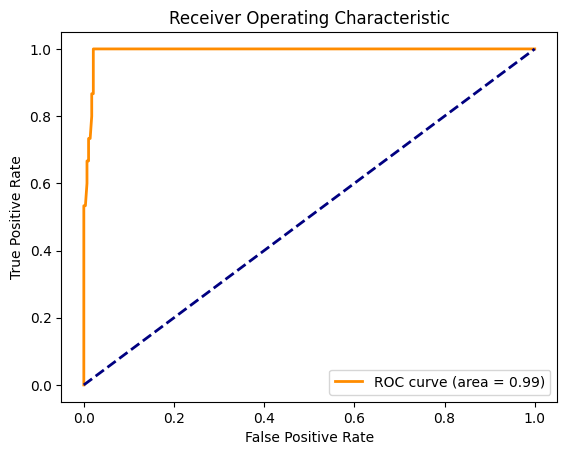

In [19]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
